In [1]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
from keras.layers import Input, Dense, Concatenate, SimpleRNN, LSTM, GRU
from keras.models import Model
from keras import backend as kb
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.experimental.numpy as tfnp
from datetime import datetime
import copy
plt.style.use('ggplot')
%run Fourier.ipynb #imports Heston option prices
%run Path_simulation.ipynb #imports path simulation functions
%run Loss_functions.ipynb #imports Loss_functions used
%run Neural_Networks.ipynb #imports different types of NN
%run Analytic_Heston.ipynb #imports function for S2 price calculation and analytic deltas.

Exception: File `'Fourier.ipynb.py'` not found.

In [53]:
#parameters used - mainly from Buehler Deep Hedging paper.

#¤What about feller condition? 2\kappa\theta>\sigma^2 for V_t>0 for all t\in[0,T]
kappa = 1#rate of mean reversion
theta = 0.04#long term variance
rho = -0.7#correlation b/t BM
sigma = 0.2#vol of vol -¤sigma=2 in paper, but maybe it should be 0.2 b/c of Feller condition
V0 = 0.04#initial vol
r = 0

S0 = 100#initial price
n = 100000#number of paths
K = 100#strike
divyield=0
steps = 30#number of rebalancings
epochs = 50#Number of times model is trained
#new variables
T = 30/365#time to expiry
dt = T/steps #step size

#Expected shortfall at level 1-alpha
alpha=0.99

#Transaction cost
TC=False
epsilon=0.01

#Consider calling the epsilon variable, sigma, instead
callprice = HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)

# Load data

In [3]:
S=np.load('Plots/Data/S.npy')
S2=np.load('Plots/Data/S2.npy')
vol=np.load('Plots/Data/vol.npy')
deltas_analytic_NoTC=np.load('Plots/Data/Analytic_deltas.npy')
input_eval_FFNN,dS_eval_FFNN = DataInputOutput_HSV(S,vol,S2) 
input_eval_RNN,dS_eval_RNN = RNN_DataInputOutput_HSV(S,vol,S2)

# Plotting
We plot the results of NN and models to compare the results from different models.   
### No TC.  
#### Hockey stick.  
Analytic, FFNN   
#### Histogram
FFNN vs. Analytic, FFNN vs. RNN  

#### 3D plot
Analytic vs. FNNN

### TC.  
#### Hockey stick
RNN

#### Histogram
FFNN vs. RNN

# Other metrics that we want to find?
Mean Error or rather mean cost of pf? (with/without callprice)  
    - Maybe rather use mean loss of hedge pf.   
    - This is kind of the price   
Sd of hedge pf

In [4]:
#loading different models
model_FFNN_NoTC=load_model('Models/FFNN_NoTC', compile=False)
model_RNN_NoTC=load_model('Models/RNN_NoTC', compile=False)
model_FFNN_TC=load_model('Models/FFNN_TC_WTerminalC', compile=False)
model_RNN_TC=load_model('Models/RNN_TC_WTerminalC', compile=False)

In [5]:
#simulating test data
n=100000
#S,vol,S2 = HestonFullTruncation_SV(n)
input_eval_FFNN,dS_eval_FFNN = DataInputOutput_HSV(S,vol,S2) 
input_eval_RNN,dS_eval_RNN = RNN_DataInputOutput_HSV(S,vol,S2)

In [6]:
#make delta for each type of model.
deltas_FFNN_NoTC=model_FFNN_NoTC.predict(input_eval_FFNN)

deltas_RNN_NoTC=model_RNN_NoTC.predict(input_eval_RNN)

deltas_FFNN_TC=model_FFNN_TC.predict(input_eval_FFNN)
deltas_FFNN_TC_tf=tf.convert_to_tensor(deltas_FFNN_TC,dtype='float64')

deltas_RNN_TC=model_RNN_TC.predict(input_eval_RNN)
deltas_RNN_TC_tf=tf.convert_to_tensor(deltas_RNN_TC,dtype='float64')

In [7]:
#Finding PfValue and Error for all different networks.

dS_eval_FFNN_tf=tf.convert_to_tensor(dS_eval_FFNN,dtype='float64')
dS_eval_RNN_tf=tf.convert_to_tensor(dS_eval_RNN,dtype='float64')

#The same for every model
payoff=np.maximum(S.T[steps]-K,0)

#make one for each model
#in noTC we include callprice. In TC we do not include it
PfValue_FFNN_NoTC=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC=np.array(PfValue_FFNN_NoTC-payoff)#What we get in the bank at expiry

PfValue_RNN_NoTC=callprice+np.sum(dS_eval_RNN*deltas_RNN_NoTC,axis=(1,2))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_RNN_NoTC=np.array(PfValue_RNN_NoTC-payoff)#What we get in the bank at expiry

PfValue_FFNN_TC=np.sum(dS_eval_FFNN*deltas_FFNN_TC,axis=(-1))-Proportional_cost(dS_eval_FFNN_tf,deltas_FFNN_TC_tf)#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_TC=np.array(PfValue_FFNN_TC-payoff)#What we get in the bank at expiry

PfValue_RNN_TC=np.sum(dS_eval_RNN*deltas_RNN_TC,axis=(1,2))-Proportional_cost_RNN(dS_eval_RNN_tf,deltas_RNN_TC_tf)#axis=-1 when FFNN, axis=(1,2) when RNN
Error_RNN_TC=np.array(PfValue_RNN_TC-payoff)#What we get in the bank at expiry

In [327]:
#finding analytic deltaas

#this is a very slow code. 
#consider only running it for 10.000 observations instead of 100.000

n_analytic=10000#we only do n=10.000 as the code is very slow.

timepoints = np.linspace(0,T-dt,steps)#Vector of timepoint where pf i adjusted.

deltas_analytic_NoTC=np.empty((n_analytic,steps*2))

start=datetime.now()
print(start)
for i in range(n_analytic):
    tmp_delta=np.empty(0)
    if(i%1000==0):
        print(i,datetime.now()-start)
    for j in range(steps):
        delta1,delta2=delta12(t=timepoints[j],v=vol[i][j],s=S[i][j])
        tmp_delta=np.append(tmp_delta,delta1)
        tmp_delta=np.append(tmp_delta,delta2)
    deltas_analytic_NoTC[i]=tmp_delta
print("calculations done in ",datetime.now()-start)

2021-11-03 11:20:24.309304
0 0:00:00
1000 0:06:32.605437
2000 0:13:39.873676
3000 0:21:08.395774
4000 0:28:29.065366
5000 0:35:34.478517
6000 0:42:44.043097
7000 0:49:52.242782
8000 0:57:05.508682
9000 1:04:03.130362
calculations done in  1:11:00.742872


In [11]:
n_analytic=10000

In [12]:
#find analytic PfValue and Error
dS_eval_analytic=dS_eval_FFNN[0:n_analytic]
payoff_analytic=payoff[0:n_analytic]

PfValue_analytic_NoTC=callprice+np.sum(dS_eval_analytic*deltas_analytic_NoTC,axis=(-1))
Error_analytic_NoTC=np.array(PfValue_analytic_NoTC-payoff_analytic)

#no TC analytic on TC scenarios
deltas_analytic_NoTC_tf=tf.convert_to_tensor(deltas_analytic_NoTC,dtype='float64')
PfValue_analytic_NoTC_wTC=np.sum(dS_eval_analytic*deltas_analytic_NoTC,axis=(-1))-Proportional_cost(dS_eval_FFNN_tf[0:n_analytic],deltas_analytic_NoTC_tf)
Error_analytic_NoTC_wTC=np.array(PfValue_analytic_NoTC_wTC-payoff_analytic)

# No TC

### Hockey Stick

##### Analytic

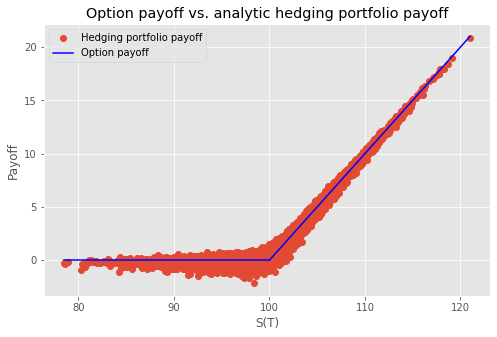

In [18]:
x=S.T[steps][0:n_analytic]#This is X-axis
y=PfValue_analytic_NoTC#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-S0],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. analytic hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hockey_NoTC_analytic_10k.png")
plt.show()

#### FFNN
Consider doing one with 10.000 and one with 100.000 paths

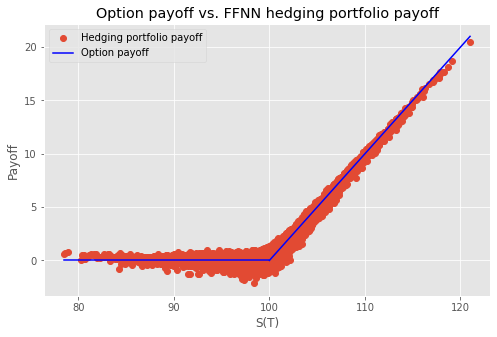

In [19]:
#10k
x=S.T[steps][0:n_analytic]#This is X-axis
y=PfValue_FFNN_NoTC[0:n_analytic]#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-S0],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. FFNN hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hockey_NoTC_FFNN_10k.png")
plt.show()

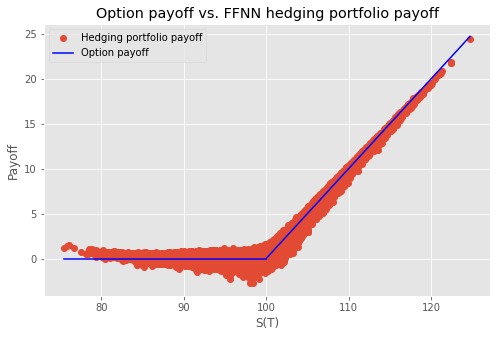

In [20]:
#100k
x=S.T[steps]#This is X-axis
y=PfValue_FFNN_NoTC#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-S0],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. FFNN hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hockey_NoTC_FFNN_100k.png")
plt.show()

### Histogram

#### FFNN vs. Analytic
This should only be 10.000 paths

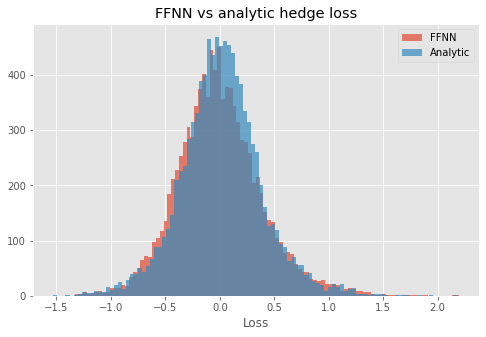

In [13]:
#only 10k first paths
bins = np.linspace(0, 5, 100)
plt.hist(-Error_FFNN_NoTC[0:n_analytic],100,alpha=0.7,label='FFNN')
plt.hist(-Error_analytic_NoTC,100,alpha=0.7,label='Analytic')
plt.legend(loc='upper right')
plt.title("FFNN vs analytic hedge loss")
plt.xlabel("Loss")

figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hist_NoTC_FFNN_analytic.png")
plt.show()

#### FFNN vs. RNN

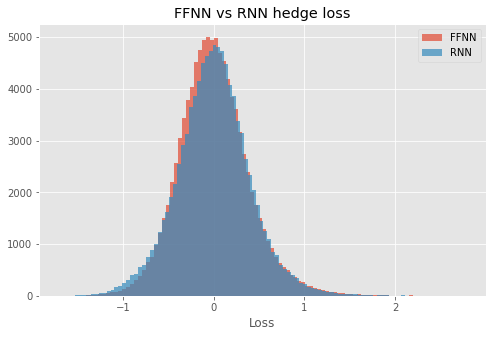

In [14]:
bins = np.linspace(0, 5, 100)
plt.hist(-Error_FFNN_NoTC,100,alpha=0.7,label='FFNN')
plt.hist(-Error_RNN_NoTC,100,alpha=0.7,label='RNN')
plt.legend(loc='upper right')
plt.title("FFNN vs RNN hedge loss")
plt.xlabel("Loss")

figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hist_NoTC_FFNN_RNN.png")
plt.show()

### 3D plot
#### Initial calculations

In [37]:
#¤make the code flexible so it can handle S_idx and vol_idx being adjusted...
time = T/2
S_idx=steps
vol_idx=steps

Sval = np.linspace(50,150,num=S_idx)
volval = np.linspace(.03,.30,num=vol_idx)

SGrid,volGrid=np.meshgrid(Sval,volval)

In [38]:
#Neural Network 3D plot values
#% make sure this is done right...
tSinput_3d = []
tim = np.linspace(T/2,T/2,steps+1)

n_3d=1

#¤is this range right? or should we switch S_idx and vol_idx so they get the opposite i,j
for i in range(S_idx):
    for j in range(vol_idx):
        timv = np.repeat(tim[i],n_3d)
        timv = np.reshape(timv,(n_3d,1))
        Sv = np.reshape(np.log(SGrid[i][j]),(n_3d,1))
        volv = np.reshape(volGrid[i][j],(n_3d,1))
        tSinput_3d.append(np.concatenate((timv,Sv,volv),1))#Input is (t,S,v)


delta1_NN = np.zeros([steps,steps])
delta2_NN = np.zeros([steps,steps])
# Hvis du læser det her, køber jeg dig en AGF trøje

for i in range(steps):
    delta_3d=model_FFNN_NoTC.predict(tSinput_3d[i*30:i*30+30])
    delta_3d_1=delta_3d[0][::2]
    delta_3d_2=delta_3d[0][1::2]
    for j in range(steps):
        delta1_NN[i][j]=delta_3d_1[j]
        delta2_NN[i][j]=delta_3d_2[j]

In [39]:
#Analytic 3D plot values

delta1_model = np.zeros([steps,steps])
delta2_model = np.zeros([steps,steps])

for i in range(steps):
    for j in range(steps):
        delta1,delta2=delta12(t=tSinput_3d[i*steps+j][0][0],s=np.exp(tSinput_3d[i*steps+j][0][1]),v=tSinput_3d[i*steps+j][0][2])
        delta1_model[i][j]=delta1
        delta2_model[i][j]=delta2

In [40]:
#Diff 3D plot values
delta1_diff=delta1_NN-delta1_model
delta2_diff=delta2_NN-delta2_model

In [64]:
np.min(delta1_diff)

-0.06044817159240656

In [65]:
np.max(delta1_diff)

0.00654684571082409

In [67]:
np.min(delta2_diff)

-381.8447936361513

In [68]:
np.max(delta2_diff)

14.740142447452428

### Delta 1
#### Analytic

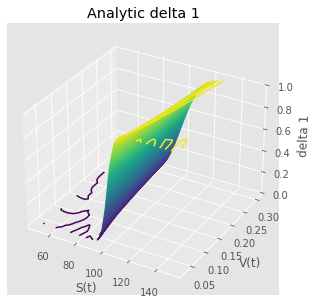

In [41]:
fig_nn = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, volGrid, delta1_model, 100)
ax.set_xlabel('S(t)')
ax.set_ylabel('V(t)')
ax.set_zlabel('delta 1');
plt.title("Analytic delta 1")
#ax.view_init(-160, 80)
figure = plt.gcf()
figure.set_size_inches(5, 5)
plt.savefig('Plots/3d_analytic_delta1_stress')

#### FFNN

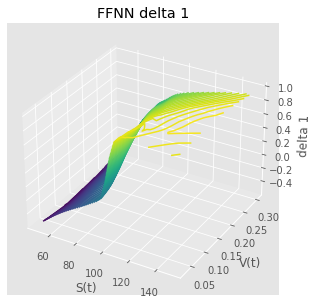

In [42]:
fig_nn = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, volGrid, delta1_NN, 100)
ax.set_xlabel('S(t)')
ax.set_ylabel('V(t)')
ax.set_zlabel('delta 1');
plt.title("FFNN delta 1")
#ax.view_init(-160, 80)
figure = plt.gcf()
figure.set_size_inches(5, 5)
plt.savefig('Plots/3d_FFNN_delta1_stress')

#### Diff

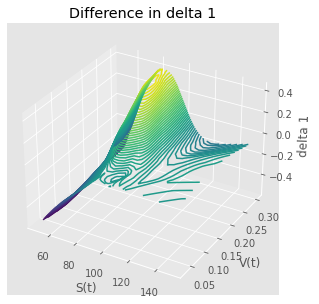

In [43]:
fig_model = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, volGrid, delta1_diff, 100)
ax.set_xlabel('S(t)')
ax.set_ylabel('V(t)')
ax.set_zlabel('delta 1');
plt.title("Difference in delta 1")
#ax.view_init(-160, 80)
figure = plt.gcf()
figure.set_size_inches(5, 5)
plt.savefig('Plots/3d_diff_delta1_stress')

### Delta 2
#### Analytic

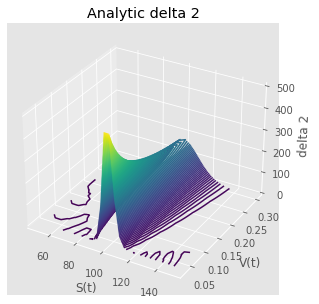

In [44]:
fig_nn = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, volGrid, delta2_model, 100)
ax.set_xlabel('S(t)')
ax.set_ylabel('V(t)')
ax.set_zlabel('delta 2');
plt.title("Analytic delta 2")
#ax.view_init(-160, 80)
figure = plt.gcf()
figure.set_size_inches(5, 5)
plt.savefig('Plots/3d_analytic_delta2_stress')

#### FFNN

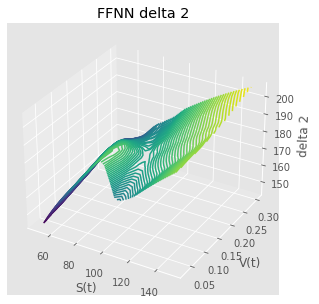

In [45]:
fig_nn = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, volGrid, delta2_NN, 100)
ax.set_xlabel('S(t)')
ax.set_ylabel('V(t)')
ax.set_zlabel('delta 2');
plt.title("FFNN delta 2")
#ax.view_init(-160, 80)
figure = plt.gcf()
figure.set_size_inches(5, 5)
plt.savefig('Plots/3d_FFNN_delta2_stress')

#### Diff

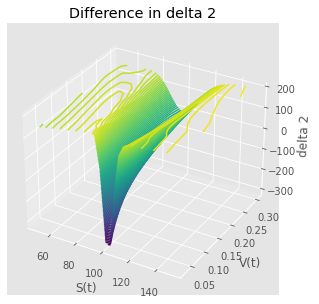

In [46]:
fig_nn = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, volGrid, delta2_diff, 100)
ax.set_xlabel('S(t)')
ax.set_ylabel('V(t)')
ax.set_zlabel('delta 2');
plt.title("Difference in delta 2")
#ax.view_init(-160, 80)
figure = plt.gcf()
figure.set_size_inches(5, 5)
plt.savefig('Plots/3d_diff_delta2_stress')

### Other metrics
#### Analytic

In [102]:
#10.000
print('Mean of Hedge error is: ',np.mean(-Error_analytic_NoTC[0:n_analytic]))
print('sd of hedge error is: ',np.std(Error_analytic_NoTC[0:n_analytic]))
print('MSE of hedge error is: ',np.mean((Error_analytic_NoTC[0:n_analytic])**2))

Mean of Hedge error is:  0.017664338352272876
sd of hedge error is:  0.3724754502652616
MSE of hedge error is:  0.13904998989973288


#### FFNN
Consider doing one with 10.000 and one with 100.000 paths

In [101]:
#10.000
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC[0:n_analytic]))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC[0:n_analytic]))
print('MSE of hedge error is: ',np.mean((Error_FFNN_NoTC[0:n_analytic])**2))

Mean of Hedge error is:  -0.002423973592846397
sd of hedge error is:  0.3949945106896334
MSE of hedge error is:  0.15602653912292175


In [100]:
#100.000
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC))
print('MSE of hedge error is: ',np.mean((Error_FFNN_NoTC)**2))

Mean of Hedge error is:  -0.001563038636844691
sd of hedge error is:  0.3910262842472329
MSE of hedge error is:  0.15290399806197802


#### RNN

In [99]:
print('Mean of Hedge error is: ',np.mean(-Error_RNN_NoTC))
print('sd of hedge error is: ',np.std(Error_RNN_NoTC))
print('MSE of hedge error is: ',np.mean((Error_RNN_NoTC)**2))

Mean of Hedge error is:  0.00195248082711615
sd of hedge error is:  0.4030486417904712
MSE of hedge error is:  0.1624520198305238


# TC

### Histogram 
#### FFNN vs. RNN

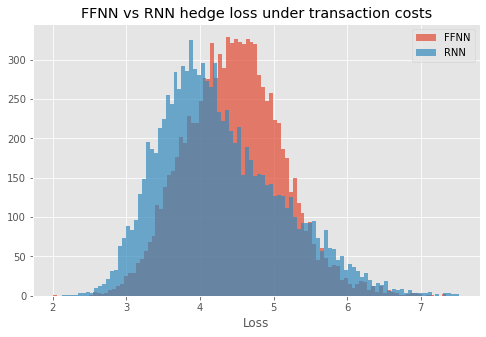

In [48]:
bins = np.linspace(0, 5, 100)
plt.hist(-Error_FFNN_TC[0:n_analytic],100,alpha=0.7,label='FFNN')
plt.hist(-Error_RNN_TC[0:n_analytic],100,alpha=0.7,label='RNN')
plt.legend(loc='upper right')
plt.title("FFNN vs RNN hedge loss under transaction costs")
plt.xlabel("Loss")

figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hist_TC_FFNN_RNN.png")
plt.show()

#### RNN vs Analytic no TC

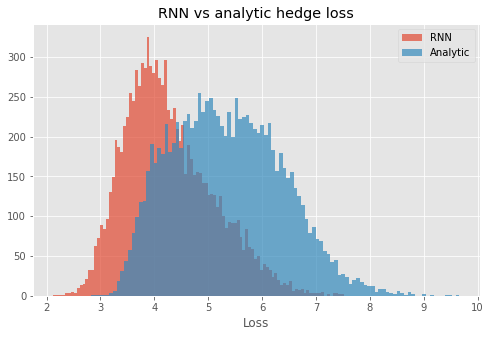

In [34]:
n_analytic=10000
#only 10k first paths
bins = np.linspace(0, 5, 100)
plt.hist(-Error_RNN_TC[0:n_analytic],100,alpha=0.7,label='RNN')
plt.hist(-Error_analytic_NoTC_wTC,100,alpha=0.7,label='Analytic')
plt.legend(loc='upper right')
plt.title("RNN vs analytic hedge loss")
plt.xlabel("Loss")

figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hist_TC_RNN_analytic.png")
plt.show()

### Hockey Stick
#### RNN

In [25]:
PfValue_RNN_TC[0:n_analytic]

<tf.Tensor: shape=(10000,), dtype=float64, numpy=
array([-2.99742938,  5.02730548, -0.36042179, ..., -3.87938481,
       -1.88828906, -4.03613416])>

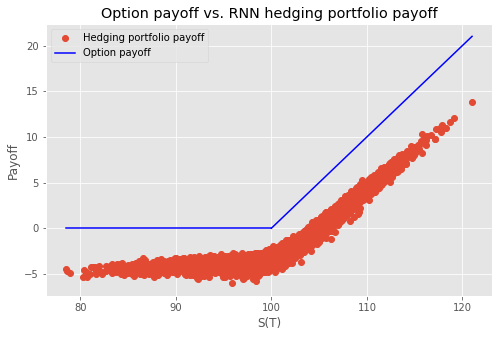

In [42]:
x=S[0:n_analytic].T[steps]#This is X-axis
y=PfValue_RNN_TC[0:n_analytic]#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-S0],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. RNN hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hockey_TC_RNN.png")
plt.show()

#### Analytic

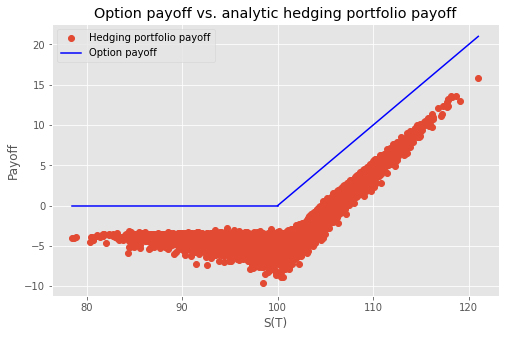

In [43]:
x=S.T[steps][0:n_analytic]#This is X-axis
y=PfValue_analytic_NoTC_wTC#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-S0],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. analytic hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hockey_TC_analytic.png")
plt.show()

### Other metrics
#### FFNN

In [17]:
print('TC are: ',kb.mean(Proportional_cost(dS_eval_FFNN_tf,deltas_FFNN_TC_tf)))
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_TC))
print('sd of hedge error is: ',np.std(Error_FFNN_TC))
print('MSE of hedge error is: ',np.mean((Error_FFNN_TC)**2))

TC are:  tf.Tensor(3.4172178124030514, shape=(), dtype=float64)
Mean of Hedge error is:  5.642202906860757
sd of hedge error is:  1.7216603649935498
MSE of hedge error is:  34.79856805457769


#### FFNN 10k

In [18]:
print('TC are: ',kb.mean(Proportional_cost(dS_eval_FFNN_tf[0:n_analytic],deltas_FFNN_TC_tf[0:n_analytic])))
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_TC[0:n_analytic]))
print('sd of hedge error is: ',np.std(Error_FFNN_TC[0:n_analytic]))
print('MSE of hedge error is: ',np.mean((Error_FFNN_TC[0:n_analytic])**2))

TC are:  tf.Tensor(2.242372917147355, shape=(), dtype=float64)
Mean of Hedge error is:  4.466858992410008
sd of hedge error is:  0.6564408863201454
MSE of hedge error is:  20.383743895306928


#### RNN

In [19]:
print('TC are: ',kb.mean(Proportional_cost_RNN(dS_eval_RNN_tf,deltas_RNN_TC_tf)))
print('Mean of Hedge error is: ',np.mean(-Error_RNN_TC))
print('sd of hedge error is: ',np.std(Error_RNN_TC))
print('MSE of hedge error is: ',np.mean((Error_RNN_TC)**2))

TC are:  tf.Tensor(3.0951350599357066, shape=(), dtype=float64)
Mean of Hedge error is:  5.375366513532884
sd of hedge error is:  1.9593285388822257
MSE of hedge error is:  32.73353347808902


#### RNN 10k

In [20]:
print('TC are: ',kb.mean(Proportional_cost_RNN(dS_eval_RNN_tf[0:n_analytic],deltas_RNN_TC_tf[0:n_analytic])))
print('Mean of Hedge error is: ',np.mean(-Error_RNN_TC[0:n_analytic]))
print('sd of hedge error is: ',np.std(Error_RNN_TC[0:n_analytic]))
print('MSE of Hedge error is: ',np.mean((Error_RNN_TC[0:n_analytic])**2))

TC are:  tf.Tensor(1.9997102629807217, shape=(), dtype=float64)
Mean of Hedge error is:  4.273817629224126
sd of hedge error is:  0.8235896504898808
MSE of Hedge error is:  18.943817040260974


#### Analytic 10k

In [21]:
print('TC are: ',kb.mean(Proportional_cost(dS_eval_FFNN_tf[0:n_analytic],deltas_analytic_NoTC_tf)))
print('Mean of Hedge error is: ',np.mean(-Error_analytic_NoTC_wTC))
print('sd of hedge error is: ',np.std(Error_analytic_NoTC_wTC))
print('MSE of Hedge error is: ',np.mean(Error_analytic_NoTC_wTC**2))

TC are:  tf.Tensor(3.0521246688603636, shape=(), dtype=float64)
Mean of Hedge error is:  5.34716914883049
sd of hedge error is:  1.0243616147288526
MSE of Hedge error is:  29.64153462393449


# S price simulation at T

In [121]:
end_price=S.T[steps]

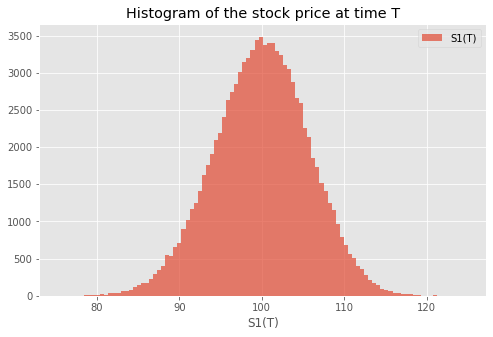

In [124]:
#only 10k first paths
bins = np.linspace(0, 5, 100)
plt.hist(end_price,100,alpha=0.7,label='S1(T)')
plt.legend(loc='upper right')
plt.title("Histogram of the stock price at time T")
plt.xlabel("S1(T)")

figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hist_S1.png")
plt.show()

# Stress testing

### Strike

In [125]:
#load models
model_FFNN_NoTC_K85=load_model('Models/FFNN_NoTC_K85', compile=False)
model_FFNN_NoTC_K115=load_model('Models/FFNN_NoTC_K115', compile=False)
model_FFNN_NoTC_K85_400e=load_model('Models/FFNN_NoTC_K85_400e', compile=False)
model_FFNN_NoTC_K115_400e=load_model('Models/FFNN_NoTC_K115_400e', compile=False)
#deltas
deltas_FFNN_NoTC_K85=model_FFNN_NoTC_K85.predict(input_eval_FFNN)
deltas_FFNN_NoTC_K115=model_FFNN_NoTC_K115.predict(input_eval_FFNN)
deltas_FFNN_NoTC_K85_400e=model_FFNN_NoTC_K85_400e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_K115_400e=model_FFNN_NoTC_K115_400e.predict(input_eval_FFNN)

#calculate deltas and PfValue maybe also Error
payoff=np.maximum(S.T[steps]-K,0)

#make one for each model
PfValue_FFNN_NoTC_K85=np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_K85,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_K85=np.array(PfValue_FFNN_NoTC_K85-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_K115=np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_K115,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_K115=np.array(PfValue_FFNN_NoTC_K115-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_K85_400e=np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_K85_400e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_K85_400e=np.array(PfValue_FFNN_NoTC_K85_400e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_K115_400e=np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_K115_400e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_K115_400e=np.array(PfValue_FFNN_NoTC_K115_400e-payoff)#What we get in the bank at expiry


#### Hockey stick

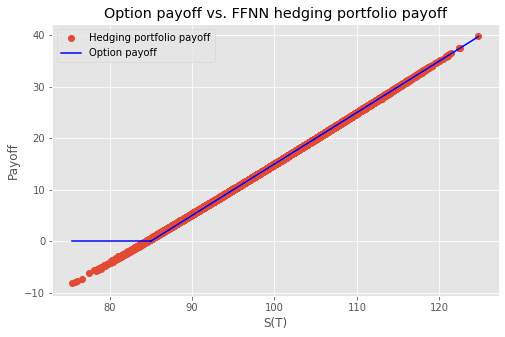

In [142]:
K=85
callprice = HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)
x=S.T[steps]#This is X-axis
y=PfValue_FFNN_NoTC_K85+callprice#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-K],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. FFNN hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hockey_FFNN_NoTC_K85.png")
plt.show()

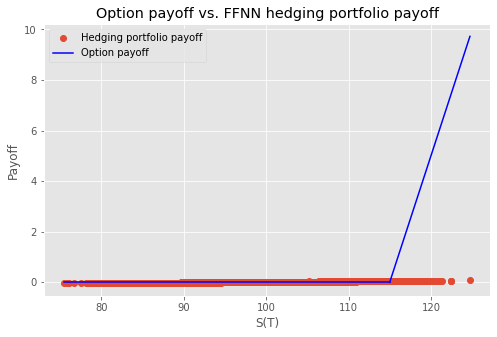

In [143]:
K=115
callprice = HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)
x=S.T[steps]#This is X-axis
y=PfValue_FFNN_NoTC_K115+callprice#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-K],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. FFNN hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hockey_FFNN_NoTC_K115.png")
plt.show()

#### 400 epochs

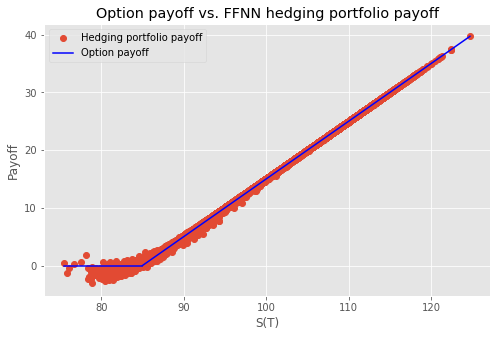

In [144]:
K=85
callprice = HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)
x=S.T[steps]#This is X-axis
y=PfValue_FFNN_NoTC_K85_400e+callprice#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-K],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. FFNN hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hockey_FFNN_NoTC_K85_400e.png")
plt.show()

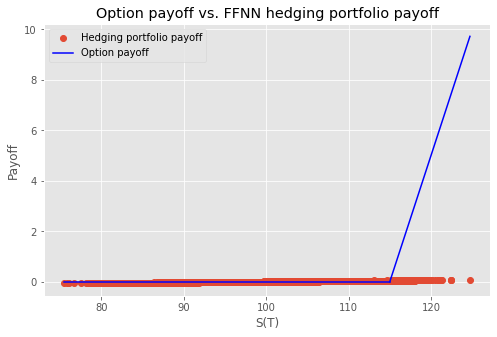

In [145]:
K=115
callprice = HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)
x=S.T[steps]#This is X-axis
y=PfValue_FFNN_NoTC_K115_400e+callprice#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-K],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. FFNN hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hockey_FFNN_NoTC_K115_400e.png")
plt.show()

In [183]:
#reset parameter
K=100
callprice = HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)

### Digital option

#### Payoff plots

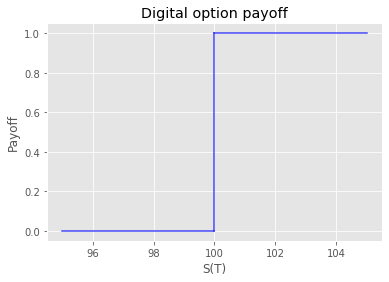

In [47]:
#payoff plot digital option
min_S=95
max_S=105
plt.plot([min_S, K], [0, 0],color='b',alpha=0.7)
plt.plot([K, max_S], [1, 1],color='b',alpha=0.7)
plt.plot([K, K], [0, 1],color='b',alpha=0.7)
plt.title("Digital option payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.savefig("Plots/Digital_option_payoff.png")
plt.show()

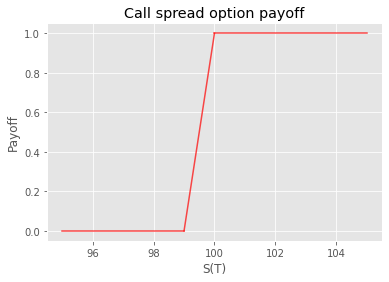

In [48]:
#payoff plot call spread
min_S=95
max_S=105
#plt.plot([min_S, K], [0, 0],color='b',alpha=0.7)
#plt.plot([K, max_S], [1, 1],color='b',alpha=0.7)

plt.plot([min_S, K-1], [0, 0],color='r',alpha=0.7)
plt.plot([K-1, K], [0, 1],color='r',alpha=0.7)
plt.plot([K, max_S], [1, 1],color='r',alpha=0.7)
#plt.plot([0, K], [0, 0],color='b'
#plt.plot([K, K*2], [0, K],color='b')
plt.title("Call spread option payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.savefig("Plots/Call_spread_payoff.png")
plt.show()

### Model performance

In [52]:
n=100000

In [53]:
#load model
model_FFNN_NoTC_digi=load_model('Models/FFNN_NoTC_digi_300', compile=False)
#deltas
deltas_FFNN_NoTC_digi=model_FFNN_NoTC_digi.predict(input_eval_FFNN)

In [54]:
#calculate deltas and PfValue maybe also Error
payoff_digi=(S.T[steps]>K)*1
digiprice=np.mean(payoff_digi)
#make one for each model
PfValue_FFNN_NoTC_digi=digiprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_digi,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_digi=np.array(PfValue_FFNN_NoTC_digi-payoff_digi)#What we get in the bank at expiry

call99=HestonFourier(spot=S0, timetoexp=T, strike=99, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)
call100=HestonFourier(spot=S0, timetoexp=T, strike=100, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)
callspread_price=call99-call100#we want a positive price to reflect what we have to pay.

diff_digi_callspread_price=callspread_price-digiprice

PfValue_callspread_digi=np.zeros(n)
#S(T)<99
PfValue_callspread_digi+=np.where(S.T[steps]<99,-diff_digi_callspread_price,0)
#S(T)>100
PfValue_callspread_digi+=np.where(S.T[steps]>100,1-diff_digi_callspread_price,0)
#99<=S(T)<=100
PfValue_callspread_digi+=np.where(np.logical_and(S.T[steps]>=99,S.T[steps]<=100),S.T[steps]-99-diff_digi_callspread_price,0)

Error_callspread_digi=np.array(PfValue_callspread_digi-payoff_digi)

#### Digi hockey stick

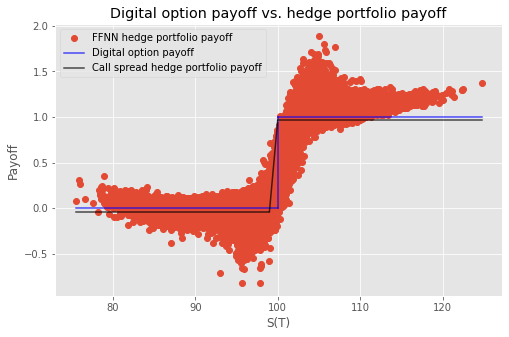

In [56]:
#payoff plot digital option
x=S.T[steps]
y=PfValue_FFNN_NoTC_digi
min_S=np.min(x)
max_S=np.max(x)
#hedge pf payoff
plt.plot(x,y,'o',label='FFNN hedge portfolio payoff')
#digi payoff
plt.plot([min_S, K], [0, 0],color='b',alpha=0.7,label='Digital option payoff')
plt.plot([K, max_S], [1, 1],color='b',alpha=0.7)
plt.plot([K, K], [0, 1],color='b',alpha=0.7)
#call spread payoff
plt.plot([min_S, K-1], [0-diff_digi_callspread_price, 0-diff_digi_callspread_price],color='k',alpha=0.7,label='Call spread hedge portfolio payoff')
plt.plot([K-1, K], [0-diff_digi_callspread_price, 1-diff_digi_callspread_price],color='k',alpha=0.7)
plt.plot([K, max_S], [1-diff_digi_callspread_price, 1-diff_digi_callspread_price],color='k',alpha=0.7)

plt.title("Digital option payoff vs. hedge portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.legend(loc='upper left')
figure = plt.gcf()
figure.set_size_inches(8, 5)
plt.savefig("Plots/Hockey_NoTC_FFNN_digi.png")
plt.show()

#### Histogram

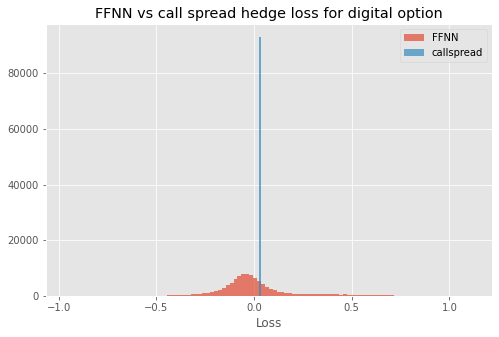

In [174]:
bins = np.linspace(0, 5, 100)
plt.hist(-Error_FFNN_NoTC_digi,100,alpha=0.7,label='FFNN')
plt.hist(-Error_callspread_digi,100,alpha=0.7,label='callspread')
plt.legend(loc='upper right')
plt.title("FFNN vs call spread hedge loss for digital option")
plt.xlabel("Loss")

figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hist_NoTC_FFNN_digi_callspread.png")
plt.show()

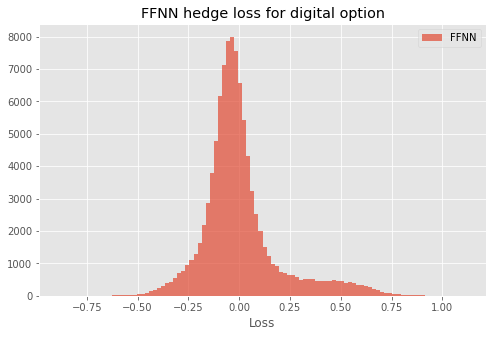

In [175]:
bins = np.linspace(0, 5, 100)
plt.hist(-Error_FFNN_NoTC_digi,100,alpha=0.7,label='FFNN')
plt.legend(loc='upper right')
plt.title("FFNN hedge loss for digital option")
plt.xlabel("Loss")

figure = plt.gcf()
figure.set_size_inches(8, 5)
plt.savefig("Plots/Hist_NoTC_FFNN_digi.png")
plt.show()

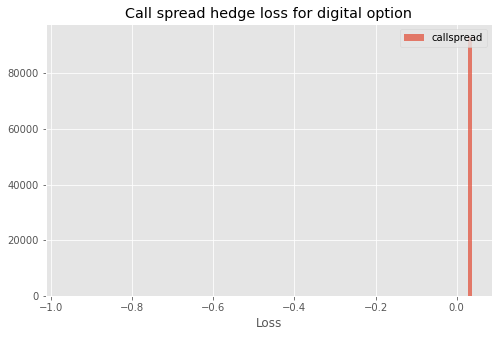

In [176]:
bins = np.linspace(0, 5, 100)
plt.hist(-Error_callspread_digi,100,alpha=0.7,label='callspread')
plt.legend(loc='upper right')
plt.title("Call spread hedge loss for digital option")
plt.xlabel("Loss")

figure = plt.gcf()
figure.set_size_inches(8, 5)
plt.savefig("Plots/Hist_NoTC_digi_callspread.png")
plt.show()

#### Other metrics

#### FFNN

In [180]:
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_digi))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_digi))

Mean of Hedge error is:  0.004165334119460733
sd of hedge error is:  0.19296916313365414


#### Call spread

In [179]:
print('Mean of Hedge error is: ',np.mean(-Error_callspread_digi))
print('sd of hedge error is: ',np.std(Error_callspread_digi))

Mean of Hedge error is:  0.0018540483915872605
sd of hedge error is:  0.14926700299096576


## Noise on variance
Consider doing it for both analytic strategy and NN strategy   
Otherwise you could do it for NN with and NN without noise

In [125]:
n_analytic=10000
S_noise=copy.deepcopy(S[0:n_analytic])
vol_noise=copy.deepcopy(vol[0:n_analytic])
S2_noise=copy.deepcopy(S2[0:n_analytic])

In [126]:
mu,sigma2=0,0.1
Error_term=(1+npr.normal(mu,np.sqrt(sigma2),(n_analytic,steps+1)))
Error_term[Error_term<0]=0
for i in range(n_analytic):
    for j in range(steps+1):
          vol_noise[i][j]*=Error_term[i][j]

In [129]:
n=10000
input_eval_FFNN_noise,dS_eval_FFNN_noise = DataInputOutput_HSV(S_noise,vol_noise,S2_noise) 

In [130]:
#analytical
#finding analytic deltaas

#this is a very slow code. 
#consider only running it for 10.000 observations instead of 100.000

n_analytic=10000#we only do n=10.000 as the code is very slow.

timepoints = np.linspace(0,T-dt,steps)#Vector of timepoint where pf i adjusted.

deltas_analytic_NoTC_noise=np.empty((n_analytic,steps*2))

start=datetime.now()
print(start)
for i in range(n_analytic):
    tmp_delta=np.empty(0)
    if(i%1000==0):
        print(i,datetime.now()-start)
    for j in range(steps):
        delta1,delta2=delta12(t=timepoints[j],v=vol_noise[i][j],s=S_noise[i][j])
        tmp_delta=np.append(tmp_delta,delta1)
        tmp_delta=np.append(tmp_delta,delta2)
    deltas_analytic_NoTC_noise[i]=tmp_delta
print("calculations done in ",datetime.now()-start)

2021-12-06 14:30:30.930073
0 0:00:00
1000 0:05:21.521932
2000 0:10:53.064876
3000 0:16:14.104274
4000 0:21:31.013686
5000 0:26:52.005021
6000 0:32:10.937823
7000 0:37:28.246638
8000 0:42:58.089384
9000 0:48:38.312540
calculations done in  0:54:32.005334


In [131]:
#load model
model_FFNN_NoTC_Noisy_Variance=load_model('Models/FFNN_NoTC_Noisy_Variance', compile=False)
#deltas
deltas_FFNN_NoTC_Noisy_Variance=model_FFNN_NoTC_Noisy_Variance.predict(input_eval_FFNN_noise)

payoff=np.maximum(S_noise.T[steps]-K,0)
PfValue_FFNN_NoTC_Noisy_Variance=callprice+np.sum(dS_eval_FFNN_noise*deltas_FFNN_NoTC_Noisy_Variance,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_Noisy_Variance=np.array(PfValue_FFNN_NoTC_Noisy_Variance-payoff)#What we get in the bank at expiry

In [132]:
deltas_FFNN_NoTC_Noisy_Variance_notrainnoise=model_FFNN_NoTC.predict(input_eval_FFNN_noise)

PfValue_FFNN_NoTC_Noisy_Variance_notrainnoise=callprice+np.sum(dS_eval_FFNN_noise*deltas_FFNN_NoTC_Noisy_Variance_notrainnoise,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_Noisy_Variance_notrainnoise=np.array(PfValue_FFNN_NoTC_Noisy_Variance_notrainnoise-payoff)#What we get in the bank at expiry

In [133]:
#find analytic PfValue and Error
dS_eval_analytic=dS_eval_FFNN_noise
payoff_analytic=payoff

PfValue_analytic_NoTC_noise=callprice+np.sum(dS_eval_analytic*deltas_analytic_NoTC_noise,axis=(-1))
Error_analytic_NoTC_noise=np.array(PfValue_analytic_NoTC_noise-payoff_analytic)

### Hockey stick

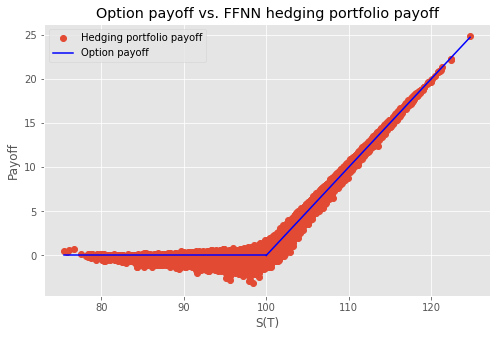

In [190]:
x=S.T[steps]#This is X-axis
y=PfValue_FFNN_NoTC_Noisy_Variance#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-K],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. FFNN hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hockey_NoTC_FFNN_Noisy_Variance.png")
plt.show()

### Histogram

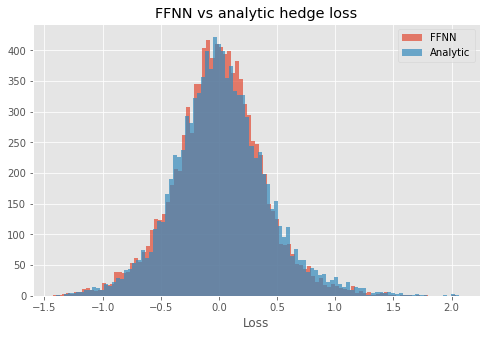

In [142]:
bins = np.linspace(0, 5, 100)
plt.hist(-Error_FFNN_NoTC_Noisy_Variance,100,alpha=0.7,label='FFNN')
plt.hist(-Error_analytic_NoTC_noise,100,alpha=0.7,label='Analytic')
plt.legend(loc='upper right')
plt.title("FFNN vs analytic hedge loss")
plt.xlabel("Loss")

figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hist_NoTC_FFNN_Noisy_variance.png")
plt.show()

### Other metrics

In [134]:
# noise test plus noise train
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_Noisy_Variance))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_Noisy_Variance))

Mean of Hedge error is:  -0.002944589561295135
sd of hedge error is:  0.38631586897483283


In [136]:
# Analytical
print('Mean of Hedge error is: ',np.mean(-Error_analytic_NoTC_noise))
print('sd of hedge error is: ',np.std(Error_analytic_NoTC_noise))

Mean of Hedge error is:  0.019749594309327812
sd of hedge error is:  0.40729416102739396


In [135]:
# noise test no noise train
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_Noisy_Variance_notrainnoise))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_Noisy_Variance_notrainnoise))

Mean of Hedge error is:  -0.0009926337481623265
sd of hedge error is:  0.46487095986960486


## Feller conditon

### Sigma=2

In [92]:
S=np.load('Plots/Data/sigma2/S.npy')[0:n_analytic]
S2=np.load('Plots/Data/sigma2/S2.npy')[0:n_analytic]
vol=np.load('Plots/Data/sigma2/vol.npy')[0:n_analytic]
deltas_analytic_NoTC_sigma2=np.load('Plots/Data/sigma2/Analytic_deltas_sigma2.npy')
input_eval_FFNN,dS_eval_FFNN = DataInputOutput_HSV(S,vol,S2) 

In [87]:
model_FFNN_NoTC_sigma2_50e=load_model('Models/FFNN_NoTC_sigma2_50e', compile=False)
model_FFNN_NoTC_sigma2_100e=load_model('Models/FFNN_NoTC_sigma2_100e', compile=False)
model_FFNN_NoTC_sigma2_150e=load_model('Models/FFNN_NoTC_sigma2_150e', compile=False)
model_FFNN_NoTC_sigma2_200e=load_model('Models/FFNN_NoTC_sigma2_200e', compile=False)

In [88]:
sigma=2
callprice=HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)
n=10000

#S,vol,S2 = HestonMomentMatching_SV(n)
#input_eval_FFNN,dS_eval_FFNN = DataInputOutput_HSV(S,vol,S2) 
#input_eval_RNN,dS_eval_RNN = RNN_DataInputOutput_HSV(S,vol,S2)

In [89]:
deltas_FFNN_NoTC_sigma2_50e=model_FFNN_NoTC_sigma2_50e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_sigma2_100e=model_FFNN_NoTC_sigma2_100e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_sigma2_150e=model_FFNN_NoTC_sigma2_150e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_sigma2_200e=model_FFNN_NoTC_sigma2_200e.predict(input_eval_FFNN)

dS_eval_FFNN_tf=tf.convert_to_tensor(dS_eval_FFNN,dtype='float64')

#The same for every model
payoff=np.maximum(S.T[steps]-K,0)

#make one for each model
PfValue_FFNN_NoTC_sigma2_50e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma2_50e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma2_50e=np.array(PfValue_FFNN_NoTC_sigma2_50e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_sigma2_100e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma2_100e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma2_100e=np.array(PfValue_FFNN_NoTC_sigma2_100e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_sigma2_150e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma2_150e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma2_150e=np.array(PfValue_FFNN_NoTC_sigma2_150e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_sigma2_200e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma2_200e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma2_200e=np.array(PfValue_FFNN_NoTC_sigma2_200e-payoff)#What we get in the bank at expiry

In [6]:
#finding analytic deltaas

#this is a very slow code. 
#consider only running it for 10.000 observations instead of 100.000

n_analytic=10000#we only do n=10.000 as the code is very slow.

timepoints = np.linspace(0,T-dt,steps)#Vector of timepoint where pf i adjusted.

deltas_analytic_NoTC_sigma2=np.empty((n_analytic,steps*2))

start=datetime.now()
print(start)
for i in range(n_analytic):
    tmp_delta=np.empty(0)
    if(i%1000==0):
        print(i,datetime.now()-start)
    for j in range(steps):
        delta1,delta2=delta12(t=timepoints[j],v=vol[i][j],s=S[i][j])
        tmp_delta=np.append(tmp_delta,delta1)
        tmp_delta=np.append(tmp_delta,delta2)
    deltas_analytic_NoTC_sigma2[i]=tmp_delta
print("calculations done in ",datetime.now()-start)

2021-12-04 14:56:04.074478
0 0:00:00.000998
1000 0:06:25.369810
2000 0:12:32.700832
3000 0:18:10.075327
4000 0:23:50.950940
5000 0:29:42.372783
6000 0:35:31.793029
7000 0:41:35.576615
8000 0:47:20.816616
9000 0:53:03.658070
calculations done in  0:58:56.218842


In [7]:
np.save('Plots/Data/sigma2/Analytic_deltas_sigma2.npy',deltas_analytic_NoTC_sigma2)

In [8]:
np.save('Plots/Data/sigma2/S.npy',S)
np.save('Plots/Data/sigma2/vol.npy',vol)
np.save('Plots/Data/sigma2/S2.npy',S2)

In [90]:
n_analytic=10000

In [93]:
#find analytic PfValue and Error
dS_eval_analytic=dS_eval_FFNN
payoff_analytic=payoff

PfValue_analytic_NoTC_sigma2=callprice+np.sum(dS_eval_analytic*deltas_analytic_NoTC_sigma2,axis=(-1))
Error_analytic_NoTC_sigma2=np.array(PfValue_analytic_NoTC_sigma2-payoff_analytic)

### Other metrics

In [94]:
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_sigma2_50e))
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_sigma2_100e))
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_sigma2_150e))
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_sigma2_200e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma2_50e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma2_100e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma2_150e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma2_200e))

Mean of Hedge error is:  -0.010901534228033641
Mean of Hedge error is:  -0.015936457285947274
Mean of Hedge error is:  -0.0778370064478358
Mean of Hedge error is:  0.0032810334940985625
sd of hedge error is:  0.4916771226942071
sd of hedge error is:  0.41752023755328443
sd of hedge error is:  0.39949902282249444
sd of hedge error is:  0.344393102097588


In [95]:
#Analytical
print('Mean of Hedge error is: ',np.mean(-Error_analytic_NoTC_sigma2))
print('sd of hedge error is: ',np.std(Error_analytic_NoTC_sigma2))

Mean of Hedge error is:  0.7030288826310341
sd of hedge error is:  0.6277316111764044


### plots to see what is going on

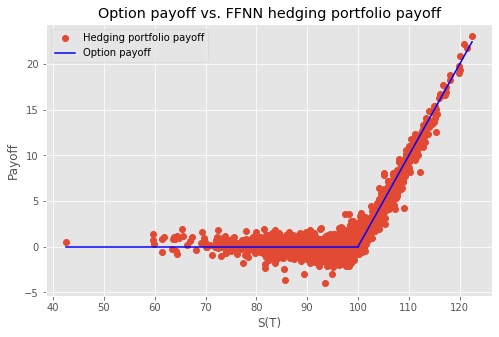

In [44]:
x=S.T[steps]#This is X-axis
y=PfValue_FFNN_NoTC_sigma2_50e#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-K],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. FFNN hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

#plt.savefig("Plots/Hockey_NoTC_FFNN_Noisy_Variance.png")
plt.show()

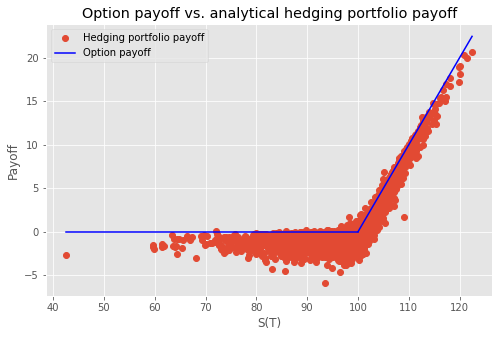

In [45]:
x=S.T[steps]#This is X-axis
y=PfValue_analytic_NoTC_sigma2#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-K],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. analytical hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

#plt.savefig("Plots/Hockey_NoTC_FFNN_Noisy_Variance.png")
plt.show()

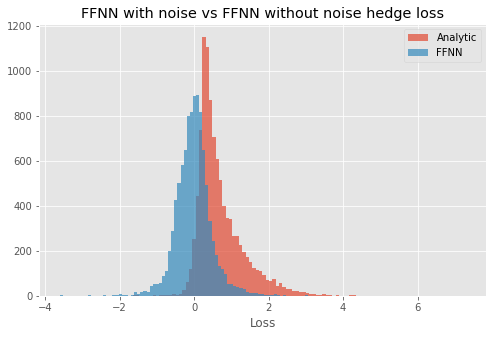

In [46]:
bins = np.linspace(0, 5, 100)
plt.hist(-Error_analytic_NoTC_sigma2,100,alpha=0.7,label='Analytic')
plt.hist(-Error_FFNN_NoTC_sigma2_50e,100,alpha=0.7,label='FFNN')
plt.legend(loc='upper right')
plt.title("FFNN with noise vs FFNN without noise hedge loss")
plt.xlabel("Loss")

figure = plt.gcf()
figure.set_size_inches(8, 5)

#plt.savefig("Plots/Hist_NoTC_FFNN_Noisy_variance.png")
plt.show()

In [35]:
#deltas
deltas_FFNN_NoTC_sigma2_50e[100]

array([6.29284799e-01, 3.93472046e+02, 6.71502411e-01, 3.58374786e+02,
       5.58054030e-01, 3.38273315e+02, 4.61029530e-01, 3.20891205e+02,
       4.70768034e-01, 3.14291229e+02, 3.56982589e-01, 2.89474701e+02,
       2.93502212e-01, 2.66927673e+02, 2.78329760e-01, 2.51898544e+02,
       2.79857010e-01, 2.37898575e+02, 2.53040344e-01, 2.23494354e+02,
       2.29591429e-01, 2.10124069e+02, 2.13724822e-01, 1.97034683e+02,
       1.99396491e-01, 1.84219315e+02, 1.91847205e-01, 1.71281647e+02,
       1.77263498e-01, 1.59428070e+02, 1.69472814e-01, 1.47718613e+02,
       1.68936729e-01, 1.37722458e+02, 1.65872633e-01, 1.29391754e+02,
       1.63168788e-01, 1.22567795e+02, 1.56860262e-01, 1.17029800e+02,
       1.53895766e-01, 1.12238205e+02, 1.50053114e-01, 1.08377441e+02,
       1.66214943e-01, 1.05448898e+02, 1.80856317e-01, 1.02787399e+02,
       1.99853271e-01, 1.00080917e+02, 2.24825203e-01, 9.73262329e+01,
       2.52716780e-01, 9.45475616e+01, 2.68666506e-01, 9.21306915e+01,
      

In [36]:
deltas_analytic_NoTC_sigma2[100]

array([6.74615972e-01, 3.56623849e+02, 7.23951141e-01, 4.26725425e+02,
       5.53287584e-01, 4.16994290e+02, 4.10635669e-01, 3.79965953e+02,
       4.70009497e-01, 4.12877903e+02, 2.54632371e-01, 3.26315602e+02,
       1.34175614e-01, 2.66070882e+02, 1.10331421e-01, 2.66213376e+02,
       1.40299020e-01, 3.05577834e+02, 1.20658746e-01, 2.97597177e+02,
       1.04632887e-01, 2.89874895e+02, 1.00404258e-01, 2.93848734e+02,
       9.96645111e-02, 3.01396881e+02, 1.08314242e-01, 3.21597531e+02,
       1.07594821e-01, 3.30800818e+02, 1.14705335e-01, 3.51447199e+02,
       1.22257406e-01, 3.74628942e+02, 1.22023243e-01, 3.89101798e+02,
       1.20981284e-01, 4.05153513e+02, 1.22831222e-01, 4.27354117e+02,
       1.28205500e-01, 4.58255130e+02, 1.22101025e-01, 4.74397545e+02,
       1.35896312e-01, 5.30413862e+02, 1.36427936e-01, 5.70269849e+02,
       1.38697354e-01, 6.22573693e+02, 1.45468437e-01, 6.97427458e+02,
       1.54355357e-01, 7.93313643e+02, 1.53765701e-01, 8.86426552e+02,
      

### Sigma=4

In [96]:
S=np.load('Plots/Data/sigma4/S.npy')[0:n_analytic]
S2=np.load('Plots/Data/sigma4/S2.npy')[0:n_analytic]
vol=np.load('Plots/Data/sigma4/vol.npy')[0:n_analytic]
deltas_analytic_NoTC_sigma4=np.load('Plots/Data/sigma4/Analytic_deltas_sigma4.npy')
input_eval_FFNN,dS_eval_FFNN = DataInputOutput_HSV(S,vol,S2) 

In [97]:
model_FFNN_NoTC_sigma4_50e=load_model('Models/FFNN_NoTC_sigma4_50e', compile=False)
model_FFNN_NoTC_sigma4_100e=load_model('Models/FFNN_NoTC_sigma4_100e', compile=False)
model_FFNN_NoTC_sigma4_150e=load_model('Models/FFNN_NoTC_sigma4_150e', compile=False)
model_FFNN_NoTC_sigma4_200e=load_model('Models/FFNN_NoTC_sigma4_200e', compile=False)

In [99]:
sigma=4
callprice=HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)
n=10000

#S,vol,S2 = HestonMomentMatching_SV(n)
#input_eval_FFNN,dS_eval_FFNN = DataInputOutput_HSV(S,vol,S2) 
#input_eval_RNN,dS_eval_RNN = RNN_DataInputOutput_HSV(S,vol,S2)

In [101]:
deltas_FFNN_NoTC_sigma4_50e=model_FFNN_NoTC_sigma4_50e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_sigma4_100e=model_FFNN_NoTC_sigma4_100e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_sigma4_150e=model_FFNN_NoTC_sigma4_150e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_sigma4_200e=model_FFNN_NoTC_sigma4_200e.predict(input_eval_FFNN)

dS_eval_FFNN_tf=tf.convert_to_tensor(dS_eval_FFNN,dtype='float64')

#The same for every model
payoff=np.maximum(S.T[steps]-K,0)

#make one for each model
PfValue_FFNN_NoTC_sigma4_50e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma4_50e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma4_50e=np.array(PfValue_FFNN_NoTC_sigma4_50e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_sigma4_100e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma4_100e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma4_100e=np.array(PfValue_FFNN_NoTC_sigma4_100e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_sigma4_150e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma4_150e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma4_150e=np.array(PfValue_FFNN_NoTC_sigma4_150e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_sigma4_200e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma4_200e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma4_200e=np.array(PfValue_FFNN_NoTC_sigma4_200e-payoff)#What we get in the bank at expiry

In [51]:
#finding analytic deltaas

#this is a very slow code. 
#consider only running it for 10.000 observations instead of 100.000

n_analytic=10000#we only do n=10.000 as the code is very slow.

timepoints = np.linspace(0,T-dt,steps)#Vector of timepoint where pf i adjusted.

deltas_analytic_NoTC_sigma4=np.empty((n_analytic,steps*2))

start=datetime.now()
print(start)
for i in range(n_analytic):
    tmp_delta=np.empty(0)
    if(i%1000==0):
        print(i,datetime.now()-start)
    for j in range(steps):
        delta1,delta2=delta12(t=timepoints[j],v=vol[i][j],s=S[i][j])
        tmp_delta=np.append(tmp_delta,delta1)
        tmp_delta=np.append(tmp_delta,delta2)
    deltas_analytic_NoTC_sigma4[i]=tmp_delta
print("calculations done in ",datetime.now()-start)

2021-12-04 16:10:30.992034
0 0:00:00.000997
1000 0:05:53.698610
2000 0:11:56.982903
3000 0:17:57.658237
4000 0:24:00.843911
5000 0:30:08.399589
6000 0:36:14.595293
7000 0:42:16.277260
8000 0:48:31.690324
9000 0:54:25.427572
calculations done in  1:00:29.999276


In [52]:
np.save('Plots/Data/sigma4/Analytic_deltas_sigma4.npy',deltas_analytic_NoTC_sigma4)

In [53]:
np.save('Plots/Data/sigma4/S.npy',S)
np.save('Plots/Data/sigma4/vol.npy',vol)
np.save('Plots/Data/sigma4/S2.npy',S2)

In [102]:
n_analytic=10000

In [104]:
#find analytic PfValue and Error
dS_eval_analytic=dS_eval_FFNN[0:n_analytic]
payoff_analytic=payoff[0:n_analytic]

PfValue_analytic_NoTC_sigma4=callprice+np.sum(dS_eval_analytic*deltas_analytic_NoTC_sigma4,axis=(-1))
Error_analytic_NoTC_sigma4=np.array(PfValue_analytic_NoTC_sigma4-payoff_analytic)

### Other metrics

In [105]:
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_sigma4_50e))
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_sigma4_100e))
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_sigma4_150e))
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_sigma4_200e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma4_50e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma4_100e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma4_150e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma4_200e))

Mean of Hedge error is:  -0.014077274505297046
Mean of Hedge error is:  -0.048412656666855174
Mean of Hedge error is:  -0.14953276209358915
Mean of Hedge error is:  0.05996722125706699
sd of hedge error is:  0.6410983485386587
sd of hedge error is:  0.4596410146406525
sd of hedge error is:  0.5313017664273585
sd of hedge error is:  0.3737474385897289


In [106]:
#Analytical
print('Mean of Hedge error is: ',np.mean(-Error_analytic_NoTC_sigma4))
print('sd of hedge error is: ',np.std(Error_analytic_NoTC_sigma4))

Mean of Hedge error is:  0.6749410541381216
sd of hedge error is:  0.9216518823676876


### plots for exploration

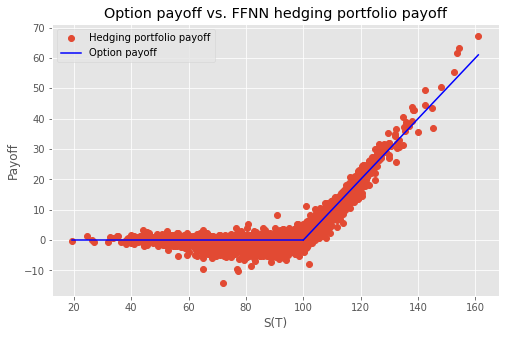

In [64]:
x=S.T[steps]#This is X-axis
y=PfValue_FFNN_NoTC_sigma4_50e#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-K],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. FFNN hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

#plt.savefig("Plots/Hockey_NoTC_FFNN_Noisy_Variance.png")
plt.show()

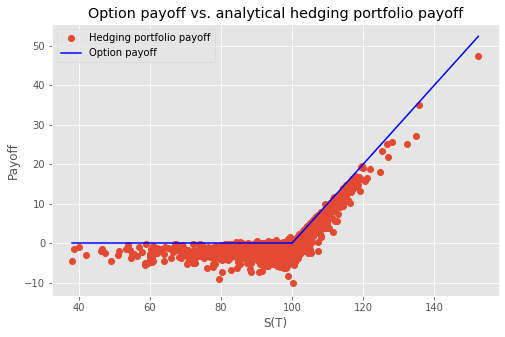

In [66]:
x=S[0:n_analytic].T[steps]#This is X-axis
y=PfValue_analytic_NoTC_sigma4#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-K],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. analytical hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

#plt.savefig("Plots/Hockey_NoTC_FFNN_Noisy_Variance.png")
plt.show()

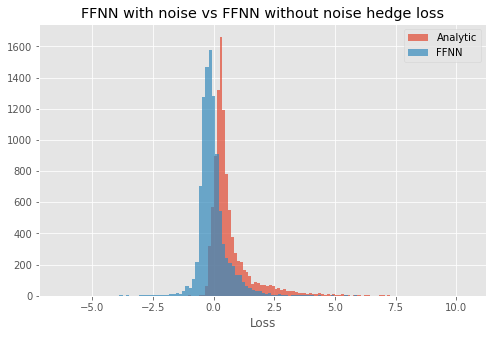

In [70]:
bins = np.linspace(0, 5, 100)
plt.hist(-Error_analytic_NoTC_sigma4,100,alpha=0.7,label='Analytic')
plt.hist(-Error_FFNN_NoTC_sigma4_50e[0:n_analytic],100,alpha=0.7,label='FFNN')
plt.legend(loc='upper right')
plt.title("FFNN with noise vs FFNN without noise hedge loss")
plt.xlabel("Loss")

figure = plt.gcf()
figure.set_size_inches(8, 5)

#plt.savefig("Plots/Hist_NoTC_FFNN_Noisy_variance.png")
plt.show()

### Sigma=6

In [107]:
S=np.load('Plots/Data/sigma6/S.npy')
S2=np.load('Plots/Data/sigma6/S2.npy')
vol=np.load('Plots/Data/sigma6/vol.npy')
deltas_analytic_NoTC_sigma6=np.load('Plots/Data/sigma6/Analytic_deltas_sigma6.npy')
input_eval_FFNN,dS_eval_FFNN = DataInputOutput_HSV(S,vol,S2) 

In [129]:
model_FFNN_NoTC_sigma6_50e=load_model('Models/FFNN_NoTC_sigma6_50e', compile=False)
model_FFNN_NoTC_sigma6_100e=load_model('Models/FFNN_NoTC_sigma6_100e', compile=False)
model_FFNN_NoTC_sigma6_150e=load_model('Models/FFNN_NoTC_sigma6_150e', compile=False)
model_FFNN_NoTC_sigma6_200e=load_model('Models/FFNN_NoTC_sigma6_200e', compile=False)

In [130]:
sigma=6
callprice=HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)
n=10000

S,vol,S2 = HestonMomentMatching_SV(n)
input_eval_FFNN,dS_eval_FFNN = DataInputOutput_HSV(S,vol,S2) 
#input_eval_RNN,dS_eval_RNN = RNN_DataInputOutput_HSV(S,vol,S2)

In [131]:
deltas_FFNN_NoTC_sigma6_50e=model_FFNN_NoTC_sigma6_50e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_sigma6_100e=model_FFNN_NoTC_sigma6_100e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_sigma6_150e=model_FFNN_NoTC_sigma6_150e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_sigma6_200e=model_FFNN_NoTC_sigma6_200e.predict(input_eval_FFNN)

dS_eval_FFNN_tf=tf.convert_to_tensor(dS_eval_FFNN,dtype='float64')

#The same for every model
payoff=np.maximum(S.T[steps]-K,0)

#make one for each model
PfValue_FFNN_NoTC_sigma6_50e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma6_50e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma6_50e=np.array(PfValue_FFNN_NoTC_sigma6_50e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_sigma6_100e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma6_100e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma6_100e=np.array(PfValue_FFNN_NoTC_sigma6_100e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_sigma6_150e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma6_150e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma6_150e=np.array(PfValue_FFNN_NoTC_sigma6_150e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_sigma6_200e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma6_200e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma6_200e=np.array(PfValue_FFNN_NoTC_sigma6_200e-payoff)#What we get in the bank at expiry

In [133]:
#finding analytic deltaas

#this is a very slow code. 
#consider only running it for 10.000 observations instead of 100.000

n_analytic=10000#we only do n=10.000 as the code is very slow.

timepoints = np.linspace(0,T-dt,steps)#Vector of timepoint where pf i adjusted.

deltas_analytic_NoTC_sigma6=np.empty((n_analytic,steps*2))

start=datetime.now()
print(start)
for i in range(n_analytic):
    tmp_delta=np.empty(0)
    if(i%1000==0):
        print(i,datetime.now()-start)
    for j in range(steps):
        delta1,delta2=delta12(t=timepoints[j],v=vol[i][j],s=S[i][j])
        tmp_delta=np.append(tmp_delta,delta1)
        tmp_delta=np.append(tmp_delta,delta2)
    deltas_analytic_NoTC_sigma6[i]=tmp_delta
print("calculations done in ",datetime.now()-start)

2021-12-07 15:08:53.700985
0 0:00:00.000988
1000 0:07:06.087543
2000 0:14:00.765751
3000 0:20:43.106371
4000 0:27:35.059334
5000 0:34:31.062336
6000 0:41:51.417550
7000 0:49:34.879506
8000 0:56:54.280146
9000 1:03:34.535758
calculations done in  1:10:03.583142


In [137]:
np.save('Plots/Data/sigma6/Analytic_deltas_sigma6.npy',deltas_analytic_NoTC_sigma6)

In [138]:
np.save('Plots/Data/sigma6/S.npy',S)
np.save('Plots/Data/sigma6/vol.npy',vol)
np.save('Plots/Data/sigma6/S2.npy',S2)

In [134]:
n_analytic=10000

In [135]:
#find analytic PfValue and Error
dS_eval_analytic=dS_eval_FFNN[0:n_analytic]
payoff_analytic=payoff[0:n_analytic]

PfValue_analytic_NoTC_sigma6=callprice+np.sum(dS_eval_analytic*deltas_analytic_NoTC_sigma6,axis=(-1))
Error_analytic_NoTC_sigma6=np.array(PfValue_analytic_NoTC_sigma6-payoff_analytic)

### Other metrics

In [139]:
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_sigma6_50e))
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_sigma6_100e))
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_sigma6_150e))
print('Mean of Hedge error is: ',np.mean(-Error_FFNN_NoTC_sigma6_200e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma6_50e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma6_100e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma6_150e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma6_200e))

Mean of Hedge error is:  0.010795436327111097
Mean of Hedge error is:  -0.03249356822500174
Mean of Hedge error is:  -0.01016944771111192
Mean of Hedge error is:  -0.08658916959570113
sd of hedge error is:  0.7920103214919765
sd of hedge error is:  0.535842217954391
sd of hedge error is:  0.44631314064967237
sd of hedge error is:  0.45359654895385115


In [140]:
#Analytical
print('Mean of Hedge error is: ',np.mean(-Error_analytic_NoTC_sigma6))
print('sd of hedge error is: ',np.std(Error_analytic_NoTC_sigma6))

Mean of Hedge error is:  0.5882807162364041
sd of hedge error is:  1.0078570870047578


### Sigma=0.2

In [54]:
model_FFNN_NoTC_sigma02_50e=load_model('Models/FFNN_NoTC_sigma02_50e', compile=False)
model_FFNN_NoTC_sigma02_100e=load_model('Models/FFNN_NoTC_sigma02_100e', compile=False)
model_FFNN_NoTC_sigma02_150e=load_model('Models/FFNN_NoTC_sigma02_150e', compile=False)
model_FFNN_NoTC_sigma02_200e=load_model('Models/FFNN_NoTC_sigma02_200e', compile=False)

In [55]:
sigma=0.2
callprice=HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)
n=10000

S,vol,S2 = HestonMomentMatching_SV(n)
input_eval_FFNN,dS_eval_FFNN = DataInputOutput_HSV(S,vol,S2) 
#input_eval_RNN,dS_eval_RNN = RNN_DataInputOutput_HSV(S,vol,S2)

deltas_FFNN_NoTC_sigma02_50e=model_FFNN_NoTC_sigma02_50e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_sigma02_100e=model_FFNN_NoTC_sigma02_100e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_sigma02_150e=model_FFNN_NoTC_sigma02_150e.predict(input_eval_FFNN)
deltas_FFNN_NoTC_sigma02_200e=model_FFNN_NoTC_sigma02_200e.predict(input_eval_FFNN)

dS_eval_FFNN_tf=tf.convert_to_tensor(dS_eval_FFNN,dtype='float64')

#The same for every model
payoff=np.maximum(S.T[steps]-K,0)

#make one for each model
PfValue_FFNN_NoTC_sigma02_50e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma02_50e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma02_50e=np.array(PfValue_FFNN_NoTC_sigma02_50e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_sigma02_100e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma02_100e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma02_100e=np.array(PfValue_FFNN_NoTC_sigma02_100e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_sigma02_150e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma02_150e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma02_150e=np.array(PfValue_FFNN_NoTC_sigma02_150e-payoff)#What we get in the bank at expiry

PfValue_FFNN_NoTC_sigma02_200e=callprice+np.sum(dS_eval_FFNN*deltas_FFNN_NoTC_sigma02_200e,axis=(-1))#axis=-1 when FFNN, axis=(1,2) when RNN
Error_FFNN_NoTC_sigma02_200e=np.array(PfValue_FFNN_NoTC_sigma02_200e-payoff)#What we get in the bank at expiry

In [56]:
#finding analytic deltaas

#this is a very slow code. 
#consider only running it for 10.000 observations instead of 100.000

n_analytic=10000#we only do n=10.000 as the code is very slow.

timepoints = np.linspace(0,T-dt,steps)#Vector of timepoint where pf i adjusted.

deltas_analytic_NoTC_sigma02=np.empty((n_analytic,steps*2))

start=datetime.now()
print(start)
for i in range(n_analytic):
    tmp_delta=np.empty(0)
    if(i%1000==0):
        print(i,datetime.now()-start)
    for j in range(steps):
        delta1,delta2=delta12(t=timepoints[j],v=vol[i][j],s=S[i][j])
        tmp_delta=np.append(tmp_delta,delta1)
        tmp_delta=np.append(tmp_delta,delta2)
    deltas_analytic_NoTC_sigma02[i]=tmp_delta
print("calculations done in ",datetime.now()-start)

2021-12-07 13:36:12.323745
0 0:00:00
1000 0:05:31.189521
2000 0:11:28.583039
3000 0:17:33.041694
4000 0:22:50.778905
5000 0:28:09.802403
6000 0:33:27.649876
7000 0:38:56.423469
8000 0:44:38.425082
9000 0:50:21.356960
calculations done in  0:55:59.459998


In [57]:
np.save('Plots/Data/sigma02/Analytic_deltas_sigma02.npy',deltas_analytic_NoTC_sigma02)

In [58]:
np.save('Plots/Data/sigma6/S.npy',S)
np.save('Plots/Data/sigma6/vol.npy',vol)
np.save('Plots/Data/sigma6/S2.npy',S2)

In [59]:
n_analytic=10000

In [61]:
#find analytic PfValue and Error
dS_eval_analytic=dS_eval_FFNN[0:n_analytic]
payoff_analytic=payoff[0:n_analytic]

PfValue_analytic_NoTC_sigma02=callprice+np.sum(dS_eval_analytic*deltas_analytic_NoTC_sigma02,axis=(-1))
Error_analytic_NoTC_sigma02=np.array(PfValue_analytic_NoTC_sigma02-payoff_analytic)

### Other metrics

In [62]:
print('Mean of Hedge error is: ',np.mean(Error_FFNN_NoTC_sigma02_50e))
print('Mean of Hedge error is: ',np.mean(Error_FFNN_NoTC_sigma02_100e))
print('Mean of Hedge error is: ',np.mean(Error_FFNN_NoTC_sigma02_150e))
print('Mean of Hedge error is: ',np.mean(Error_FFNN_NoTC_sigma02_200e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma02_50e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma02_100e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma02_150e))
print('sd of hedge error is: ',np.std(Error_FFNN_NoTC_sigma02_200e))

Mean of Hedge error is:  0.008823762242634009
Mean of Hedge error is:  0.02105530548653621
Mean of Hedge error is:  0.02962859737097801
Mean of Hedge error is:  0.042500100335146805
sd of hedge error is:  0.37210335090935004
sd of hedge error is:  0.36359165148960026
sd of hedge error is:  0.44511811163932374
sd of hedge error is:  0.39226991018632185


In [63]:
#Analytical
print('Mean of Hedge error is: ',np.mean(-Error_analytic_NoTC_sigma02))
print('sd of hedge error is: ',np.std(Error_analytic_NoTC_sigma02))

Mean of Hedge error is:  0.010905636075509663
sd of hedge error is:  0.3620529168924606


In [30]:
#reset parameter
sigma=0.2

# Save data
We save the crucial data so we can make change to plots or new plots with the same data

In [358]:
#Simulated data
np.save('Plots/Data/S.npy',S)
np.save('Plots/Data/vol.npy',vol)
np.save('Plots/Data/S2.npy',S2)

#Analytic deltas
np.save('Plots/Data/Analytic_deltas.npy',deltas_analytic_NoTC)

#can be loaded again with 
#np.load('Plots/Data/S.npy')

# Load data

In [4]:
S=np.load('Plots/Data/S.npy')
S2=np.load('Plots/Data/S2.npy')
vol=np.load('Plots/Data/vol.npy')
deltas_analytic_NoTC=np.load('Plots/Data/Analytic_deltas.npy')
input_eval_FFNN,dS_eval_FFNN = DataInputOutput_HSV(S,vol,S2) 
input_eval_RNN,dS_eval_RNN = RNN_DataInputOutput_HSV(S,vol,S2)

# Delta hedging only using S1. 
Hence we do not trade in the vol swap.

In [ ]:
deltas_analytic_NoTC

In [120]:
deltas_analytic_NoTC_only1=copy.deepcopy(deltas_analytic_NoTC)
for i in range(deltas_analytic_NoTC_only1.shape[0]):
    deltas_analytic_NoTC_only1[i][1::2]=0

In [133]:
n_analytic=10000
#find analytic PfValue and Error
payoff=np.maximum(S.T[steps]-K,0)
dS_eval_analytic=dS_eval_FFNN[0:n_analytic]
payoff_analytic=payoff[0:n_analytic]

PfValue_analytic_NoTC_only1=np.sum(dS_eval_analytic*deltas_analytic_NoTC_only1,axis=(-1))
Error_analytic_NoTC_only1=np.array(PfValue_analytic_NoTC_only1-payoff_analytic)


PfValue_analytic_NoTC=np.sum(dS_eval_analytic*deltas_analytic_NoTC,axis=(-1))
Error_analytic_NoTC=np.array(PfValue_analytic_NoTC-payoff_analytic)

In [129]:
np.mean(Error_analytic_NoTC_only1)

-2.2787960480805207

In [131]:
np.std(Error_analytic_NoTC_only1)

0.41407121550838644

In [134]:
np.std(Error_analytic_NoTC)

0.3724754502652616

In [135]:
np.mean(Error_analytic_NoTC)

-2.2950444799701275